In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
import tensorflow as tf
import random

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
merged_n = pd.read_csv(r'/content/drive/MyDrive/Dissertation_10862121/merged_n.csv')

In [ ]:
save_dir = "r'/content/drive/MyDrive/Dissertation_10862121/"

In [ ]:
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
merged_n['GMT'] = pd.to_datetime(merged_n['GMT'])
merged_n['Date'] = pd.to_datetime(merged_n['Date'])
merged_n.set_index('GMT', inplace=True)

Consumption

In [ ]:
#Lag for the hour before
merged_n['lag_1_hour_energy'] = merged_n['Total Household Consumption (N)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_n[f'lag_{i}_day_energy'] = merged_n['Total Household Consumption (N)'].shift(24 * i)

Temperature

In [ ]:
#Lag for the hour before
merged_n['lag_1_hour_temp'] = merged_n['Hourly Temperature (C)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_n[f'lag_{i}_day_temp'] = merged_n['Hourly Temperature (C)'].shift(24 * i)

Radiation

In [ ]:
#Lag for the hour before
merged_n['lag_1_hour_rad'] = merged_n['Hourly Global Radiation (KJ/m2)'].shift(1)

#Lags for the same hour for the past 7 days
for i in range(1, 8):
    merged_n[f'lag_{i}_day_rad'] = merged_n['Hourly Global Radiation (KJ/m2)'].shift(24 * i)

Rolling Statistics - Consumption

In [ ]:
window_size = 72
merged_n['rolling_mean_consumption'] = merged_n['Total Household Consumption (N)'].rolling(window=window_size).mean()

Cyclical Features

In [ ]:
merged_n['hour_sin'] = np.sin(2 * np.pi * merged_n['Hour'] / 24)
merged_n['hour_cos'] = np.cos(2 * np.pi * merged_n['Hour'] / 24)
merged_n['month_sin'] = np.sin(2 * np.pi * merged_n['Month'] / 12)
merged_n['month_cos'] = np.cos(2 * np.pi * merged_n['Month'] / 12)

Weather Combination Variables

In [ ]:
merged_n['temp_humidity_interaction'] = merged_n['Hourly Temperature (C)'] * merged_n['Hourly Relative Humidity (%)']

In [ ]:
merged_n['temp_rad_interaction'] = merged_n['Hourly Temperature (C)'] * merged_n['Hourly Global Radiation (KJ/m2)']

Weighted Observations (More weight to more recent)

In [ ]:
alpha = 0.9
merged_n['ewm_consumption'] = merged_n['Total Household Consumption (N)'].ewm(alpha=alpha).mean()

Difference between consecutive hours

In [ ]:
merged_n['consumption_diff'] = merged_n['Total Household Consumption (N)'].diff()

Drop Missing Value Rows after Feature Engineering (1 week worth of data, 168 rows)

In [ ]:
merged_n.dropna(inplace=True)

In [ ]:
merged_n['IsHoliday'] = merged_n['IsHoliday'].astype(int)

In [ ]:
non_num_columns = merged_n.select_dtypes(exclude=['int64', 'float64']).columns
print(non_num_columns)

Index(['Date', 'Time'], dtype='object')


In [ ]:
#Dropping columns that aren't numerical (needed for model input)
merged_n= merged_n.drop(columns=['Date', 'Time'])

In [ ]:
non_num_columns = merged_n.select_dtypes(exclude=['int64', 'float64']).columns
print(non_num_columns)

Index([], dtype='object')


Feature Selection

In [ ]:
merged_n = merged_n.drop(columns=["Hourly Mean Windspeed (kn)"])

hour_sin: 0.4542096379693078
rolling_mean_consumption: 0.23250154163505996
hour_cos: 0.16922600082804362
consumption_diff: 0.08207524542672523
temp_rad_interaction: 0.04442884772000439
temp_humidity_interaction: 0.01185239103825915
month_cos: 0.0031718780793439693
month_sin: 0.0025344573032558384


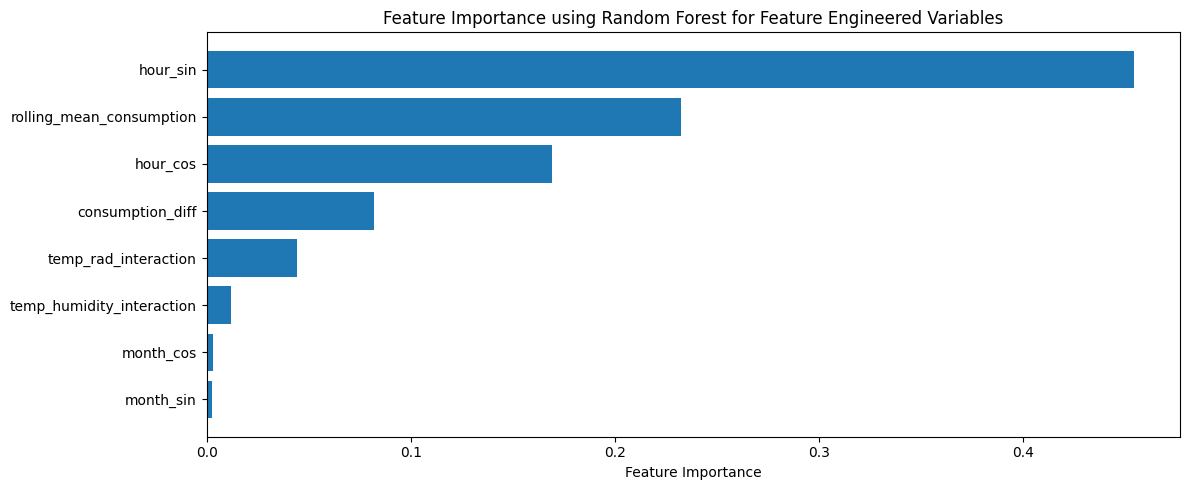

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = [
    "rolling_mean_consumption",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "temp_humidity_interaction",
    "temp_rad_interaction",
    "consumption_diff",
]

X = merged_n[features]
y = merged_n['Total Household Consumption (N)']

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = rf.feature_importances_

importance = sorted(zip(features, feature_importance), key=lambda x:x[1], reverse=True)
for feature, score in importance:
    print(f"{feature}: {score}")

plt.figure(figsize=(12, 5))
sorted_idx = feature_importance.argsort()
plt.barh([features[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance using Random Forest for Feature Engineered Variables")
plt.tight_layout()
plt.show()

lag_7_day_energy: 0.6329299106069396
lag_1_day_energy: 0.32589611386014505
lag_1_hour_energy: 0.024865499451571318
lag_6_day_energy: 0.004845249467547612
lag_3_day_energy: 0.0030405576461277296
lag_5_day_energy: 0.002965464297396496
lag_4_day_energy: 0.002764795885258634
lag_2_day_energy: 0.002692408785013561


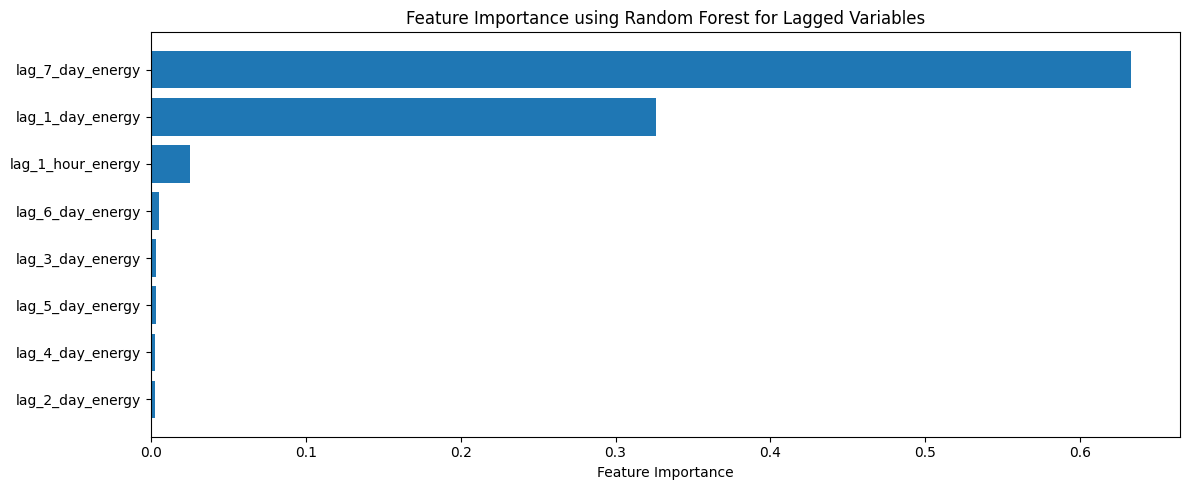

In [ ]:
features = [
    "lag_1_hour_energy",
    "lag_1_day_energy",
    "lag_2_day_energy",
    "lag_3_day_energy",
    "lag_4_day_energy",
    "lag_5_day_energy",
    "lag_6_day_energy",
    "lag_7_day_energy",
]

X = merged_n[features]
y = merged_n['Total Household Consumption (N)']

#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = rf.feature_importances_

importance = sorted(zip(features, feature_importance), key=lambda x:x[1], reverse=True)
for feature, score in importance:
    print(f"{feature}: {score}")

plt.figure(figsize=(12, 5))
sorted_idx = feature_importance.argsort()
plt.barh([features[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance using Random Forest for Lagged Variables")
plt.tight_layout()
plt.show()